# Imports

In [1]:
import os
import torch
from tqdm import tqdm
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import gc

if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)


from src.eval.eval_metrics import precision,recall,create_cls_targets, accuracy, eval_reg
from src.eval.eval_utils import plt_training_metrics, gather_best_metrics
from src.eval.vis_scanpath import draw_scanpath_mpl
from src.model.model_io import load_models_with_data
from src.training.training_utils import move_data_to_device, compute_loss


## Methods

In [2]:
def get_coords(idx, x,y, fixation_len, reg_out):
    if torch.all(x < 2):
        x = x.clone()
        x[:,:,0] = x[:,:,0] * 512
        x[:,:,1] = x[:,:,1] * 320
    x_coords = x[idx,:,:2].cpu().numpy().T
    y_coords = y[idx,:fixation_len[idx],:2].cpu().numpy().T
    reg_coords = reg_out[idx,:fixation_len[idx],:2].cpu().numpy().T
    x_coords = x_coords[:,::-1]
    y_coords = y_coords[:,::-1]
    reg_coords = reg_coords[:,::-1]
    return x_coords, y_coords, reg_coords

def batch_to_list(x, fixation_len = None):
    # convert from padded batch [B,T,F] to list of numpy arrays with shape [F,N]
    x_list = []
    for i in range(x.size(0)):
        l = 0
        if fixation_len is None:
            l = x.size(1)
        else:
            l = fixation_len[i]
        x_i = x[i,:l, :].cpu().numpy().T
        x_list.append(x_i)
    return x_list

def plot_classification_scores(cls_out,fixation_len, title="Classification Scores"):
    acum = np.zeros(7)
    count = 0
    skipped_count = 0
    for i in range(cls_out.shape[0]):
        cls_out_sample = cls_out[i]
        cls_out_sample = torch.sigmoid(cls_out_sample).cpu().numpy().T
        if fixation_len[i] < 3 or fixation_len[i] > cls_out_sample.shape[1]-4:
            skipped_count += 1
            continue
        acum += cls_out_sample[0,fixation_len[i]-3: fixation_len[i]+4 ]
        count +=1
    avg = acum / count
    image_data = avg.reshape(7, 1).T
    plt.figure(figsize=(7,1)) # Set the figure size to be tall and thin
    plt.imshow(image_data, cmap='gray', interpolation='nearest', aspect='auto')
    text_color = 'green' 
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            score = image_data[i, j]
            
            plt.text(j, i, f'{score:.2f}', 
                     ha="center", va="center", color=text_color, fontsize=10)
    print(f'Skipped samples: {skipped_count} out of {cls_out.shape[0]}')
    plt.title(title)
    plt.xticks(range(7), [f'Token {i-3}' if i != 3 else 'END' for i in range(7)]) # Optional: keep y-axis labels for reference
    plt.yticks([])
    plt.show()
    
def invert_transforms(inputs, outputs, dataloader):
    pred_reg = outputs['reg']
    gt_reg = inputs['tgt']
    transforms = dataloader.path_dataset.transforms
    # reverse the transforms
    for transform in reversed(transforms):
        if transform.modify_y:
            pred_reg = transform.inverse(pred_reg)
            gt_reg = transform.inverse(gt_reg)
    outputs['reg'] = pred_reg
    inputs['tgt'] = gt_reg
    return inputs, outputs



# Eval

## Review Metrics

In [3]:

# ckpt_path = ['outputs\\2025-11-19\\18-48-14',
#              'outputs\\2025-11-27\\17-35-19',
#              'outputs\\2025-11-28\\12-28-42'
#              ]
ckpt_path = ['outputs\\2025-12-03\\17-10-55']

metric_path = [os.path.join(p, 'metrics.json') for p in ckpt_path]

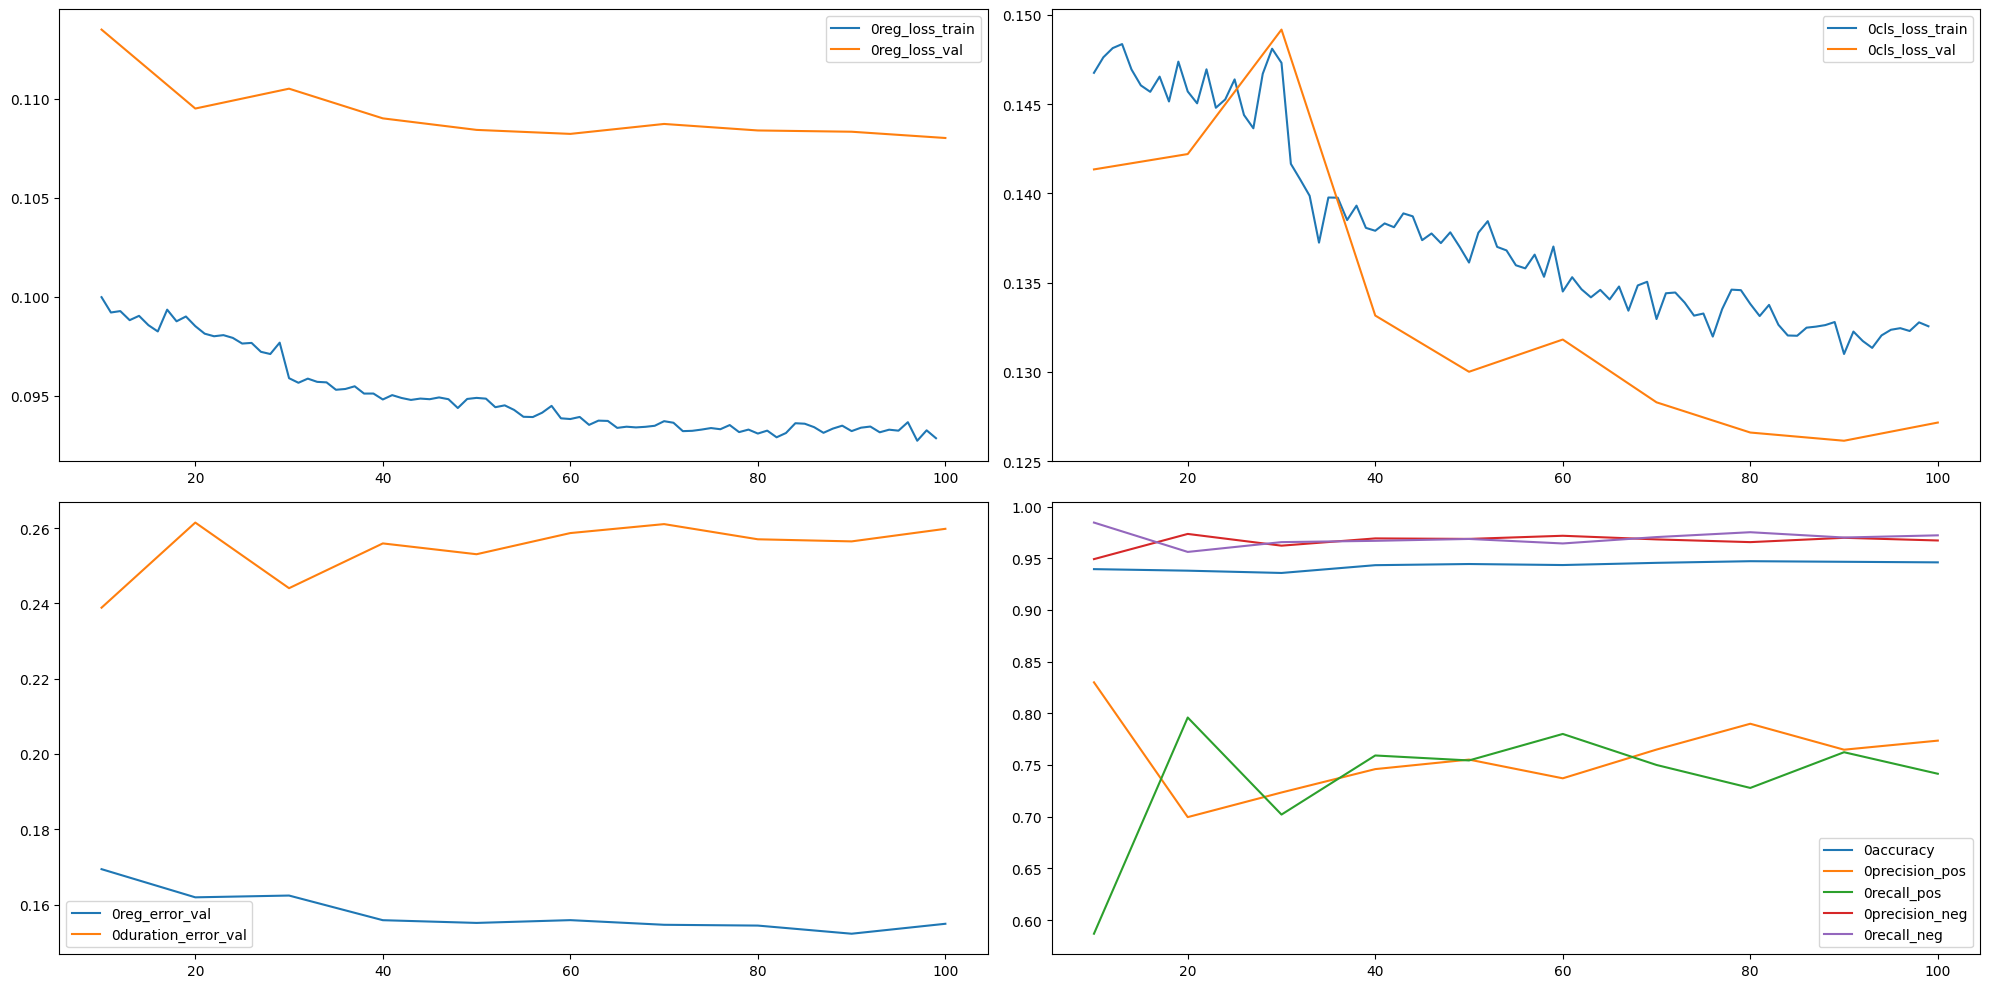

In [4]:
plt_training_metrics(metric_path, start_epoch=10)

In [5]:
ckpt_path = ['outputs\\2025-11-19\\18-48-14',
             'outputs\\2025-11-27\\17-35-19',
             'outputs\\2025-11-28\\12-28-42',
             'outputs\\2025-12-03\\17-10-55']

metric_path = [os.path.join(p, 'metrics.json') for p in ckpt_path]
gather_best_metrics(metric_path)

,epoch,reg_loss_train,reg_loss_val,cls_loss_train,cls_loss_val,accuracy,precision_pos,recall_pos,precision_neg,recall_neg,reg_error_val,duration_error_val
0,100,7607.521662,7566.260010,0.234150,0.233732,0.890130,0.741319,0.329663,0.913140,1.000000,NaN,NaN
1,100,8060.989434,6853.475754,0.262169,0.255997,0.887517,0.572673,0.119068,0.896838,1.000000,60.499606,68.711616
2,100,7479.535542,7927.933896,0.252484,0.254622,0.881869,0.587735,0.153930,0.892783,1.000000,68.865608,74.855592
3,100,0.092843,0.108017,0.132552,0.127158,0.947127,0.829949,0.795916,0.973512,0.984502,0.152242,0.238872


## Checkout Output

### Eval Just One Batch

In [7]:
input_outputs = torch.load('inputs_outputs.pth', map_location='cpu')
# input_outputs.pop(2)
# input_outputs.pop(2)
pass

In [8]:
for model in input_outputs:
    print(model['model_name'])
    print(model['checkpoint_path'])
    print(len(model['inputs']))
    

path model
outputs/2025-12-10/15-57-12
38
mixer model RoPE
outputs/2025-12-12/19-18-29
41
mixer model no RoPE
outputs/2025-12-15/11-50-27
36


In [9]:
for model in input_outputs:
    print(model['model_name'])
    acum_cls_loss = 0
    acum_reg_loss = 0
    acum_coord_error = 0
    acum_duration_error = 0
    count = 0
    for i in range(len(model['inputs'])):
        input, output = model['inputs'][i], model['outputs'][i]
        cls_loss, reg_loss = compute_loss(input, output)
        reg_out, cls_out = output['reg'], output['cls']
        y, y_mask, fixation_len = input['tgt'], input['tgt_mask'], input['fixation_len']
        reg_error, dur_error = eval_reg(reg_out, y, y_mask)
        acum_cls_loss += cls_loss.item()
        acum_reg_loss += reg_loss.item()
        acum_coord_error += reg_error
        acum_duration_error += dur_error
        count += 1
    print(f'Cls Loss: {acum_cls_loss/count:.4f}, Reg Loss: {acum_reg_loss/count:.4f}')
    print(f'Regression error (pixels): {acum_coord_error/count:.4f}, Duration error ({acum_duration_error/count:.4f})')
    print('--------------------------------')

path model
Cls Loss: 0.2518, Reg Loss: 6504.6901
Regression error (pixels): 63.3029, Duration error (84.5842)
--------------------------------
mixer model RoPE
Cls Loss: 0.2854, Reg Loss: 9768.8875
Regression error (pixels): 80.8002, Duration error (98.6125)
--------------------------------
mixer model no RoPE
Cls Loss: 0.2648, Reg Loss: inf
Regression error (pixels): 73.3002, Duration error (1816408606620537634502475776.0000)
--------------------------------


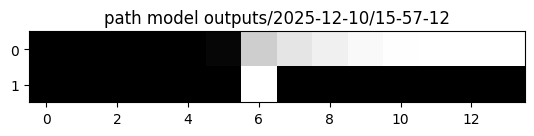

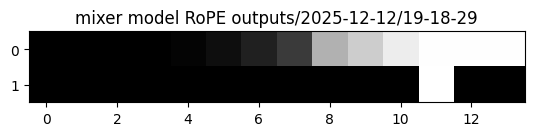

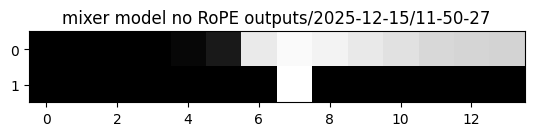

In [10]:
for i, model in enumerate(input_outputs):
    idx = randint(0,len(model['inputs']) - 1)
    reg_out, cls_out = model['outputs'][i]['reg'], model['outputs'][i]['cls']
    y, y_mask, fixation_len = model['inputs'][i]['tgt'], model['inputs'][i]['tgt_mask'], model['inputs'][i]['fixation_len']
    cls_out_sample = cls_out[idx]
    cls_out_sample = torch.sigmoid(cls_out_sample).cpu().numpy().T
    cls_targets = create_cls_targets(cls_out, fixation_len)
    cls_targets_sample = cls_targets[idx].cpu().numpy().T
    # vstack
    pair = np.vstack((cls_out_sample, cls_targets_sample)).T
    plt.imshow(pair.T, cmap='gray')
    plt.title(f'{model["model_name"]} {model["checkpoint_path"]}')
    plt.show()

Skipped samples: 18 out of 128


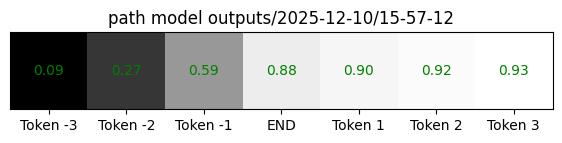

Skipped samples: 13 out of 128


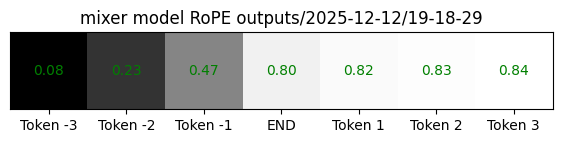

Skipped samples: 24 out of 128


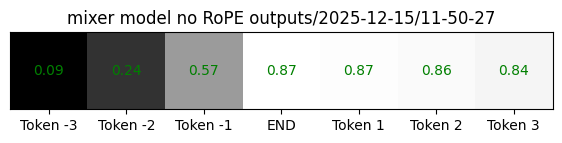

In [11]:

# put the value in each pixel
for i, model in enumerate(input_outputs):
    reg_out, cls_out = model['outputs'][i]['reg'], model['outputs'][i]['cls']
    y, y_mask, fixation_len = model['inputs'][i]['tgt'], model['inputs'][i]['tgt_mask'], model['inputs'][i]['fixation_len']
    plot_classification_scores(cls_out, fixation_len, title=f"{model['model_name']} {model['checkpoint_path']}")

c:\Users\ulloa\OneDrive\Desktop\Practicas\projectes\Dataset\src\eval\vis_scanpath.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[0], y[0], s=marker_size, c=end_color, zorder=5)


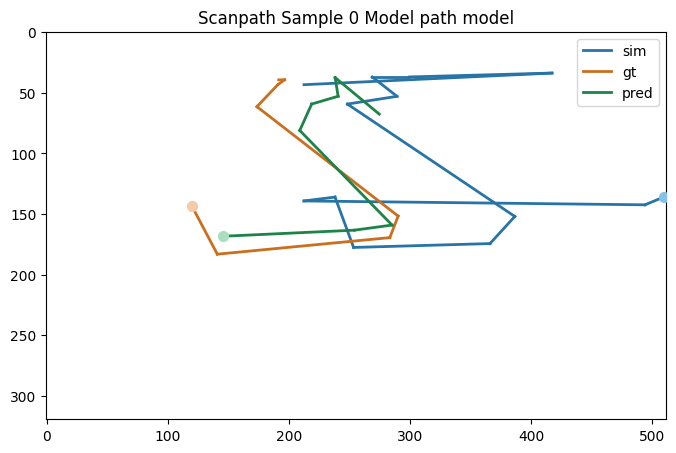

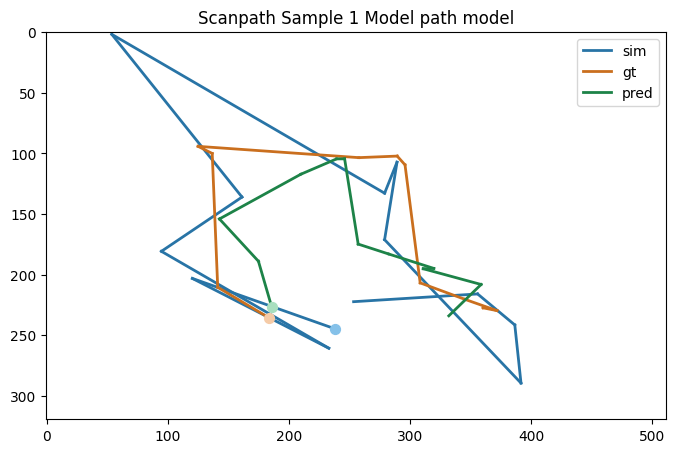

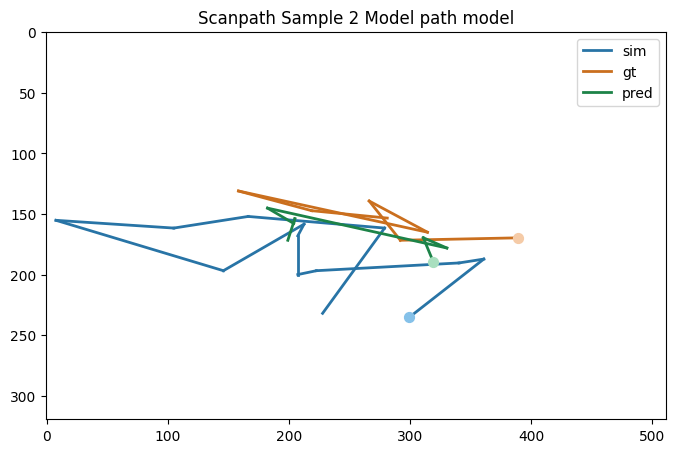

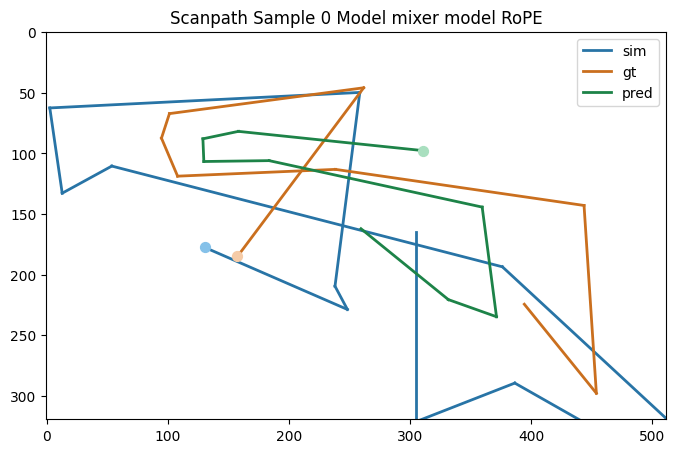

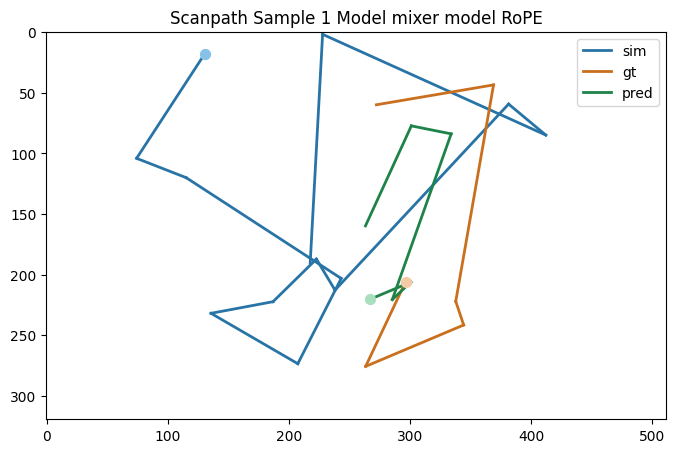

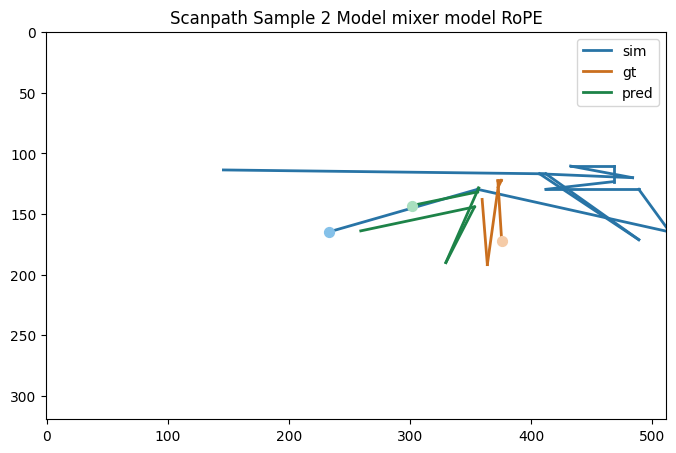

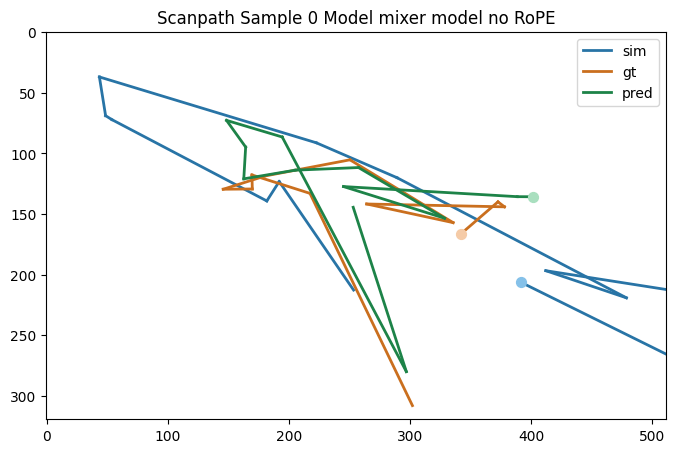

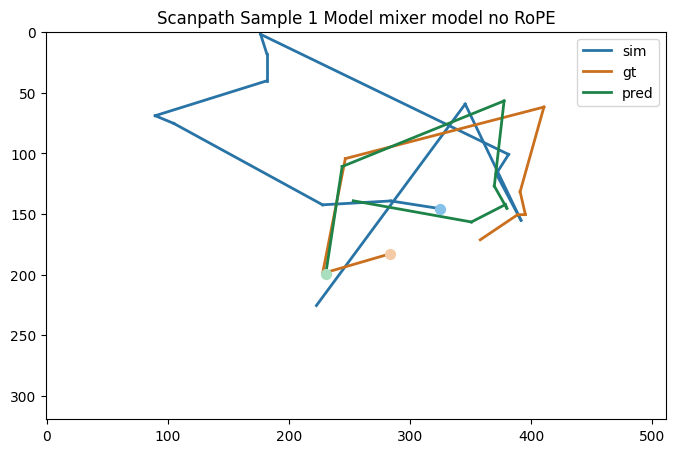

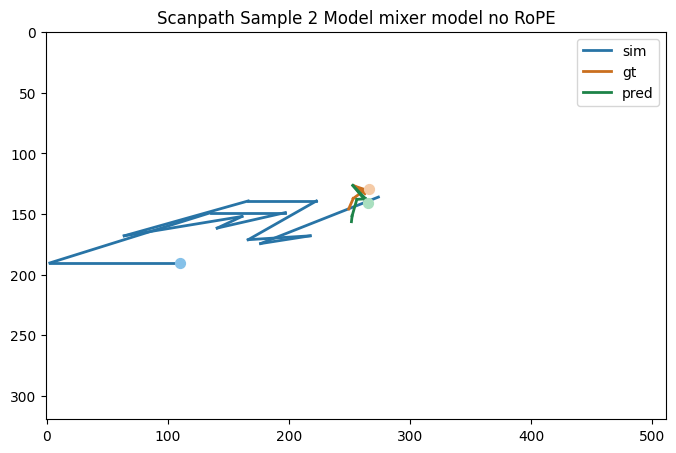

In [12]:

for model in input_outputs:
    for i in range(3):
        idx = randint(0,len(model['inputs']) - 1)
        reg_out, cls_out = model['outputs'][idx]['reg'], model['outputs'][idx]['cls']
        x, y, fixation_len = model['inputs'][idx]['src'], model['inputs'][idx]['tgt'], model['inputs'][idx]['fixation_len']
        x_coords, y_coords, reg_coords = get_coords(idx, x, y, fixation_len,reg_out)
        img = np.ones((320,512,3),dtype=np.uint8)*255

        label = ['sim', 'gt', 'pred']

        traj = [x_coords,
                y_coords, 
                reg_coords]
        traj_colors = [(40/255, 116/255, 166/255), # blue
                    (202/255, 111/255, 30/255), # orange
                    (29/255, 131/255, 72/255)] # green

        end_point_colors = [(133/255, 193/255, 233/255),
                            (245/255, 203/255, 167/255),
                            (169/255, 223/255, 191/255)]
        fig, ax = plt.subplots(figsize=(8,8))
        for traj, color, end_color, lbl in zip(traj, traj_colors, end_point_colors, label):
            ax = draw_scanpath_mpl(ax, traj[0],traj[1], color=color, end_color=end_color, label=lbl)

        plt.title(f'Scanpath Sample {i} Model {model["model_name"]}')
        plt.imshow(img)
        plt.legend()
        #plt.savefig(f'Output/scanpath_{i}_model_{model["model_name"]}.png')
        plt.show()


### Load Stats


In [13]:
acc_list = []
reg_loss_list = []
cls_loss_list = []
pre_pos_list = []
rec_pos_list = []
pre_neg_list = []
rec_neg_list = []
coord_error_list = []
dur_error_list = []
all_model_x_list = []
all_model_y_list = []
all_model_reg_list = []
for model in input_outputs:
    acc_acum = 0
    cls_loss_acum = 0
    reg_loss_acum = 0
    pre_pos_acum = 0
    rec_pos_acum = 0
    pre_neg_acum = 0
    rec_neg_acum = 0
    coord_error_acum = 0
    duration_error_acum = 0
    reg_results = []
    y_results = []
    x_results = []
    count = 0
    for i in range(len(model['inputs'])):
        input = model['inputs'][i]
        output = model['outputs'][i]
        cls_loss, reg_loss = compute_loss(input, output)
        
        y, y_mask, fixation_len = input['tgt'], input['tgt_mask'], input['fixation_len']
        x = input['src']
        reg_out, cls_out = output['reg'], output['cls']
        cls_loss_acum += cls_loss.item()
        reg_loss_acum += reg_loss.item()
        cls_targets = create_cls_targets(cls_out, fixation_len)
        acc_acum += accuracy(cls_out, y_mask, cls_targets)
        pre_pos_acum += precision(cls_out, y_mask, cls_targets)
        rec_pos_acum += recall(cls_out, y_mask, cls_targets)
        pre_neg_acum += precision(cls_out, y_mask, cls_targets, cls = 0)
        rec_neg_acum += recall(cls_out, y_mask, cls_targets, cls = 0)
        coord_error, dur_error = eval_reg(reg_out, y, y_mask)
        coord_error_acum += coord_error
        duration_error_acum += dur_error
        reg_results += batch_to_list(reg_out, fixation_len)
        y_results += batch_to_list(y, fixation_len)
        x_results += batch_to_list(x)
        count += 1
    acc_list.append(acc_acum/count)
    reg_loss_list.append(reg_loss_acum/count)
    cls_loss_list.append(cls_loss_acum/count)
    pre_pos_list.append(pre_pos_acum/count)
    rec_pos_list.append(rec_pos_acum/count)
    pre_neg_list.append(pre_neg_acum/count)
    rec_neg_list.append(rec_neg_acum/count)
    coord_error_list.append(coord_error_acum/count)
    dur_error_list.append(duration_error_acum/count)
    all_model_x_list.append(x_results)
    all_model_y_list.append(y_results)
    all_model_reg_list.append(reg_results)

In [14]:
# plot evaluation metrics using pandas 
import pandas as pd
# Transpose the dataframe so models are columns and metrics are rows
metrics_df = pd.DataFrame({
    'Reg_Loss': reg_loss_list,
    'Cls_Loss': cls_loss_list,
    'Accuracy': acc_list,
    'Precision_Pos': pre_pos_list,
    'Recall_Pos': rec_pos_list,
    'Precision_Neg': pre_neg_list,
    'Recall_Neg': rec_neg_list,
    'Coord_Error': coord_error_list,
    'Dur_Error': dur_error_list
}, index=[f'{input_outputs[i]['model_name']}' for i in range(len(input_outputs))])
metrics_df = metrics_df.transpose()
metrics_df

,path model,mixer model RoPE,mixer model no RoPE
Reg_Loss,6504.690147,9768.887457,inf
Cls_Loss,0.251816,0.285401,2.648435e-01
Accuracy,0.886430,0.875053,8.825651e-01
Precision_Pos,0.494305,0.495264,4.932144e-01
Recall_Pos,0.962993,0.920675,9.158999e-01
Precision_Neg,0.994761,0.987425,9.877572e-01
Recall_Neg,0.876895,0.868698,8.783138e-01
Coord_Error,63.302900,80.800203,7.330016e+01
Dur_Error,84.584152,98.612452,1.816409e+27


In [15]:
ori_x = []
for path in all_model_x_list[0]:
    path_clone = path.copy()
    path_clone[0] = path_clone[0]*512
    path_clone[1] = path_clone[1]*320
    ori_x.append(path_clone)

In [16]:
gaze_list = [(ori_x,'sim_noise',1/16), 
             (all_model_y_list[0],'gt',1/16),   
             *[(all_model_reg_list[i],f'{input_outputs[i]['model_name']}', 1/16) for i in range(len(all_model_reg_list))]]

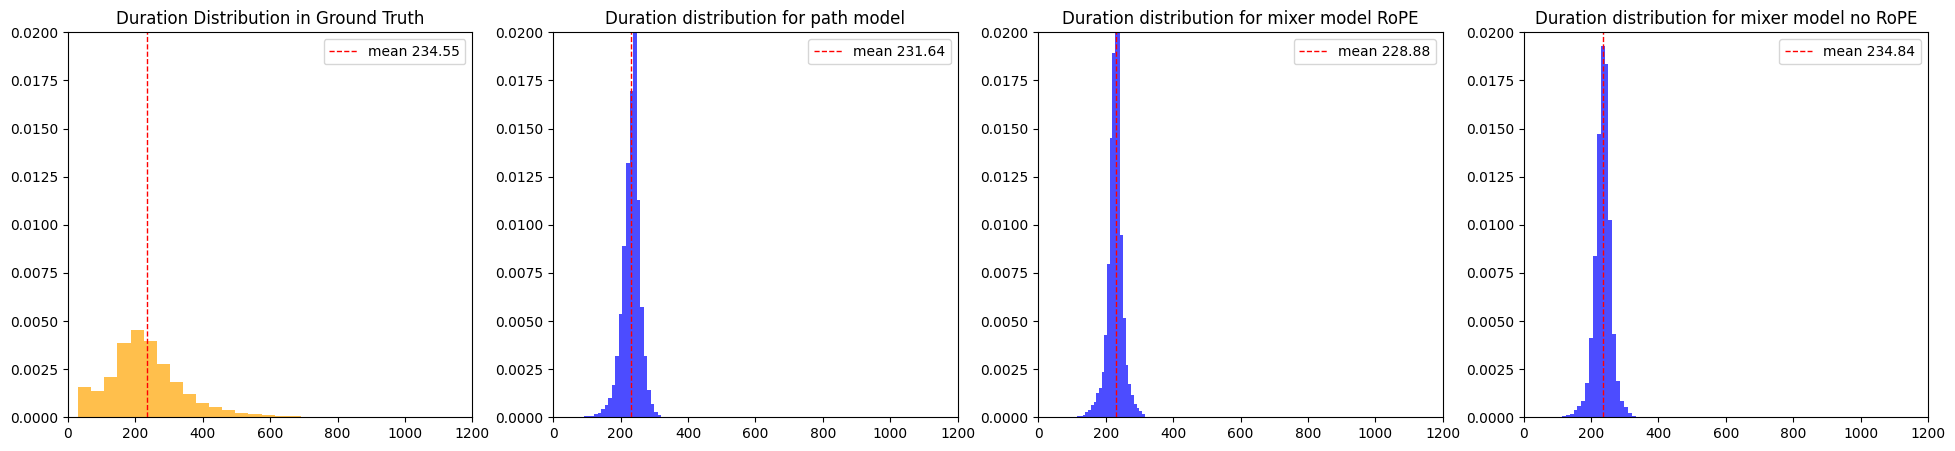

In [33]:
concatenated_y = np.concat([y[2] for y in all_model_y_list[0]])

# plot a hist of each array in two subplots
fig, axs = plt.subplots(1,1 + len(all_model_reg_list), figsize=(6*(1 + len(all_model_reg_list)),  5))
axs[0].hist(concatenated_y, bins=30, color='orange', alpha=0.7, density=True)
axs[0].set_title('Duration Distribution in Ground Truth')
axs[0].set_xlim(0, 1200)
axs[0].set_ylim(0, 0.02)
axs[0].axvline(np.mean(concatenated_y), color='red', linestyle='dashed', linewidth=1, label = f'mean {np.mean(concatenated_y):.2f}')
axs[0].legend()
for i in range(len(all_model_reg_list)):
    concatenated_reg = np.concat([reg[2] for reg in all_model_reg_list[i]])
    concatenated_reg = concatenated_reg[concatenated_reg < 1200]
    axs[i+1].hist(concatenated_reg, bins=30, color='blue', alpha=0.7, density=True)
    axs[i+1].set_title(f'Duration distribution for {input_outputs[i]['model_name']}')
    axs[i+1].set_xlim(0, 1200)
    axs[i+1].set_ylim(0, 0.02)
    axs[i+1].axvline(np.mean(concatenated_reg), color='red', linestyle='dashed', linewidth=1, label = f'mean {np.mean(concatenated_reg):.2f}')
    axs[i+1].legend()
plt.show()

    


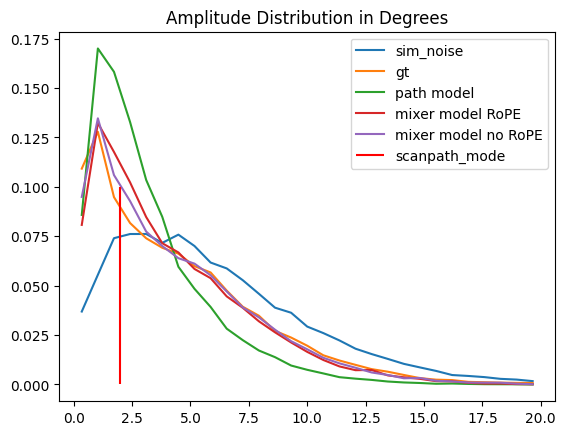

In [18]:
from src.eval.eval_utils import plot_amplitude_dist, plot_angle_distribution, plot_autocorrelation, plot_consecutive_angles, plot_vector_dist, calculate_relative_vectors                        
plot_amplitude_dist([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list],
                    [gaze[2] for gaze in gaze_list])

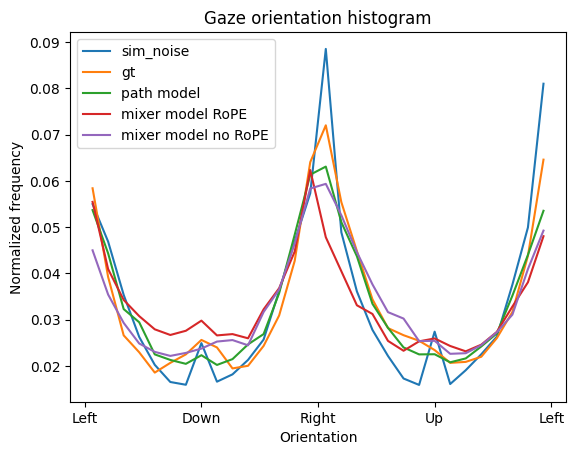

In [19]:
plot_angle_distribution([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

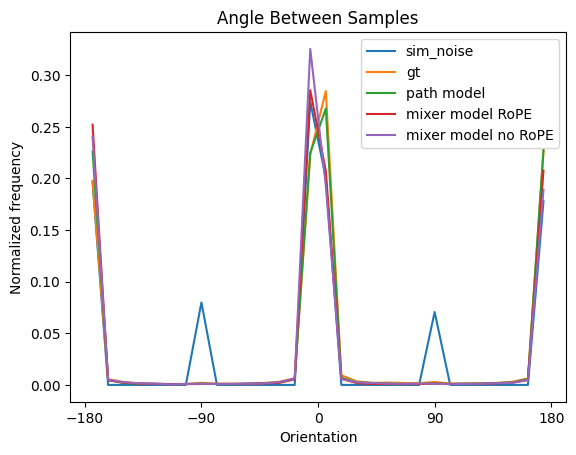

In [20]:
plot_consecutive_angles([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

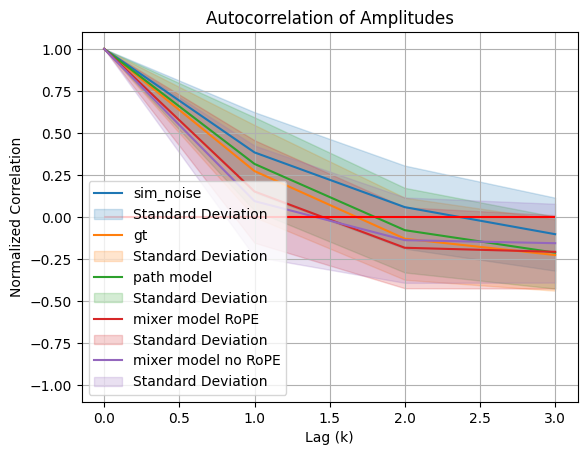

In [21]:
plot_autocorrelation([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list], min_len=4)
plt.show()

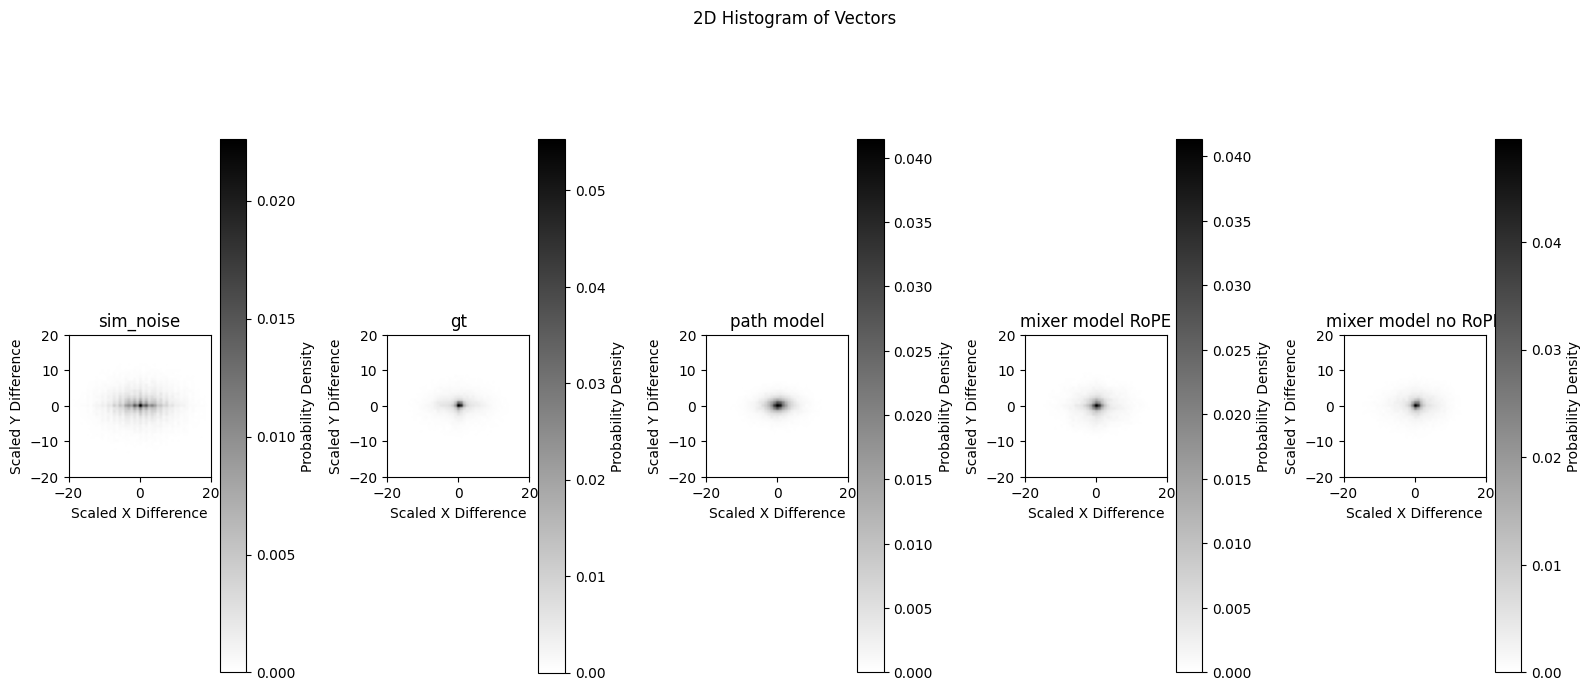

In [22]:
plot_vector_dist([[np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in gaze[0]] for gaze in gaze_list],
                 [gaze[2] for gaze in gaze_list], 
                 [gaze[1] for gaze in gaze_list],)

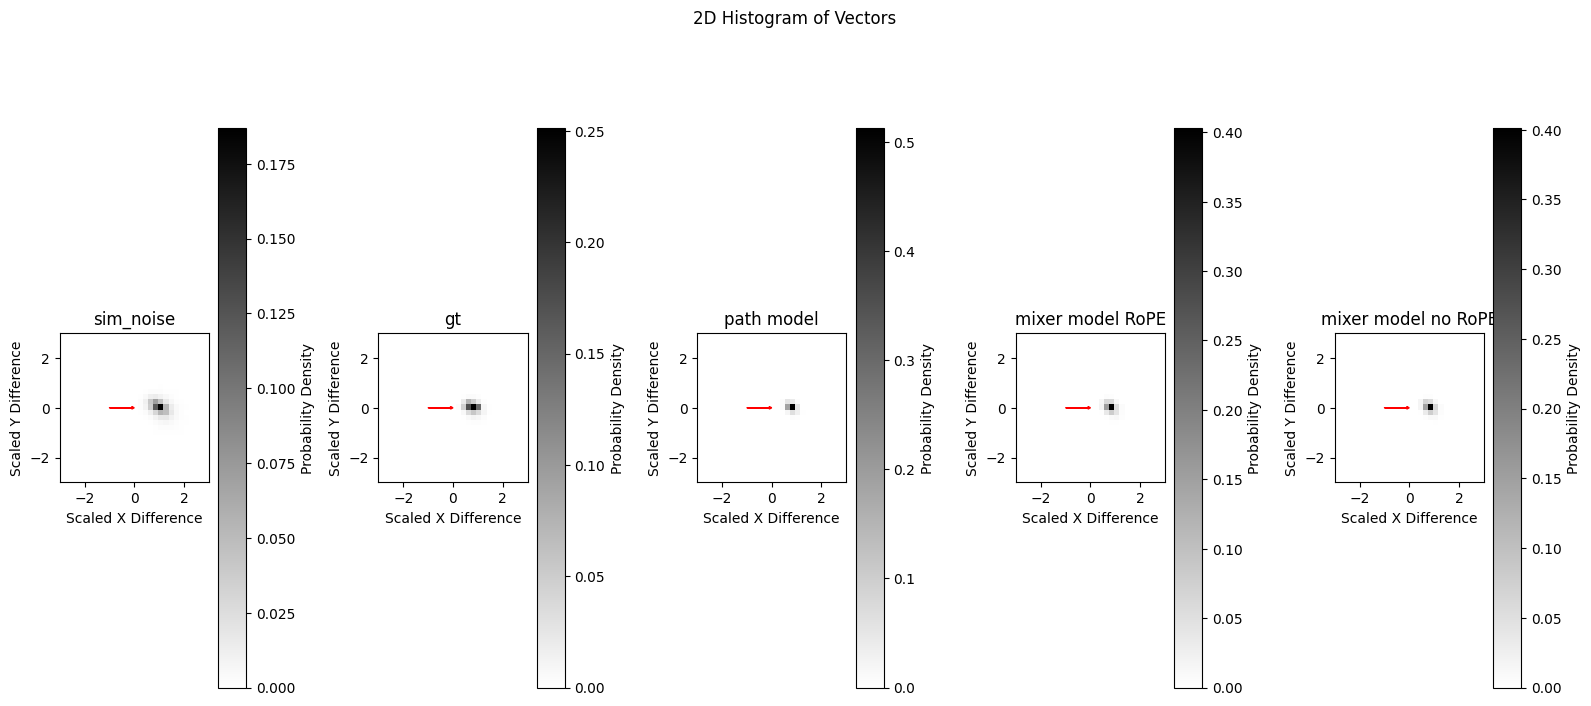

In [23]:
plot_vector_dist([[calculate_relative_vectors(gaze_sample) for gaze_sample in gaze[0]] for gaze in gaze_list],
                    [1 for _ in gaze_list],
                    [gaze[1] for gaze in gaze_list],-3,3,30, arrow= True)

plt.show()